# 🐱🐶 CNN Image Classification: Cat vs. Dog

**📌 Introduction**  
This notebook is for **intermediate data scientists** looking to explore **Convolutional Neural Networks (CNNs)**, **transfer learning**, and **data augmentation**. The goal is to build, fine-tune, and optimize deep learning models for **image classification** in a practical and hands-on way.  

**🔍 Overview**  
We're tackling the classic **Cat vs. Dog** classification problem using CNNs! 🐾  
We’ll experiment with both **custom models** and **pre-trained architectures**, including **VGG16** and **MobileNetV2**. To improve accuracy and generalization, we'll also apply **data augmentation** techniques.  

**🎯 Goals**  
**Find the best CNN model** that suits our dataset by comparing architectures, fine-tuning parameters, and applying data augmentation for optimal performance.


This notebook is all about exploring, learning, and improving our models—just like a fun deep learning adventure! 😃 Let’s take on the challenge and find the best CNN model for our dataset. Ready to dive in? 💪🚀

# Setup and Load Data 🛠📂

## Import Libraries 📚

In [1]:
# Create a new environment and set it as the active kernel in this Jupyter Notebook.
# !pip install numpy pandas matplotlib opencv-python pillow tensorflow seaborn scikit-learn requests

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import zipfile
import os # os (operating system) module helps manage files and system settings
import cv2 # OpenCV (Open Computer Vision)
from PIL import Image

import collections
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import RandomFlip, RandomRotation

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import requests

## Setup 🛠

In [3]:
# Avoid OOM (Out Of Memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Load Data 📥

💡Download: Cats vs Dogs Dataset from Kaggle https://www.kaggle.com/datasets/tongpython/cat-and-dog/data?select=test_set

💡Unzip archive.zip, then compress the training_set and test_set folders separately to save space. Ensure training_set.zip and test_set.zip are in the same directory as this Notebook.

In [8]:
dataset_path = "dataset"

# Create dataset directory if it doesn’t exist
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    print(f"Created dataset directory: {dataset_path}")

# Function to extract zip files
def extract_zip(zip_filename, target_folder):
    extract_to = os.path.join(dataset_path, target_folder)
    if not os.path.exists(extract_to):  # Avoid re-extracting
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)  # Extract inside 'dataset'
        print(f"{zip_filename} extracted successfully!")
    else:
        print(f"{zip_filename} is already extracted.")

# Extract training and test sets
extract_zip("training_set.zip", "training_set")
extract_zip("test_set.zip", "test_set")

# Verify Folder Structure
print("Training set contents:", os.listdir(os.path.join(dataset_path, "training_set")))
print("Test set contents:", os.listdir(os.path.join(dataset_path, "test_set")))

Created dataset directory: dataset
training_set.zip extracted successfully!
test_set.zip extracted successfully!
Training set contents: ['cats', 'dogs']
Test set contents: ['cats', 'dogs']


Type: <class 'numpy.ndarray'>
Shape: (457, 466, 3)


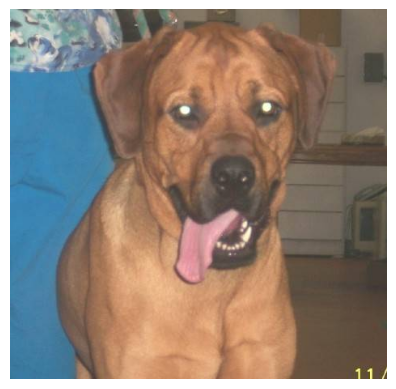

In [4]:
# Load image using OpenCV
img = cv2.imread(os.path.join(dataset_path, 'training_set/dogs', 'dog.30.jpg'))

# Print type and shape
print("Type:", type(img))
print("Shape:", img.shape)  

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image correctly
plt.imshow(img_rgb)
plt.axis("off")  # Hide axes
plt.show()

In [5]:
# Define dataset directories
train_path = os.path.join(dataset_path, "training_set")
test_path = os.path.join(dataset_path, "test_set") 

# Load Training Data
train_dataset = image_dataset_from_directory(
    train_path, 
    image_size=(256, 256), 
    batch_size=16, 
    color_mode="rgb"
)


# Load Testing Data
test_dataset = image_dataset_from_directory(
    test_path, 
    image_size=(256, 256), 
    batch_size=16, 
    color_mode="rgb"
)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


# EDA 🔍

## Data size 📏

In [17]:
# Count number of batches in each dataset
num_samples_train = tf.data.experimental.cardinality(train_dataset).numpy()
num_samples_test = tf.data.experimental.cardinality(test_dataset).numpy()
num_samples_train, num_samples_test

(501, 127)

In [16]:
# Count the number of samples in each dataset
train_samples = sum(1 for _ in train_dataset.unbatch())
test_samples = sum(1 for _ in test_dataset.unbatch())

print(f"Total training samples: {train_samples}")
print(f"Total test samples: {test_samples}")

Total training samples: 8005
Total test samples: 2023


## Label Mapping 🏷

In [7]:
print("Class Names:", train_dataset.class_names)

Class Names: ['cats', 'dogs']


Class labels are assigned alphabetically by default:
- Cat → 0
- Dog → 1

## Display Some Samples 🖼

In [8]:
def display_samples(dataset, num_samples=10, batch=False):
    if batch:
        dataset = dataset.unbatch()  # Unbatch only if dataset is batched

    samples = list(dataset.take(num_samples))  # Convert to list for iteration

    plt.figure(figsize=(num_samples * 3, 3))
    for i, (image, label) in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy().astype("uint8"))  # Convert tensor to NumPy and ensure correct dtype
        plt.title("Cat" if int(label.numpy()) == 0 else "Dog")  # Ensure label is an integer
        plt.axis("off")

    plt.show()

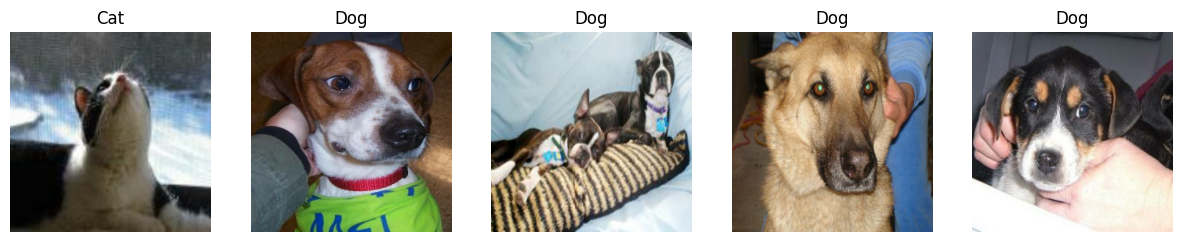

In [9]:
display_samples(train_dataset, num_samples=5, batch=True)  # Change num_samples as needed

## Class Distribution 📈

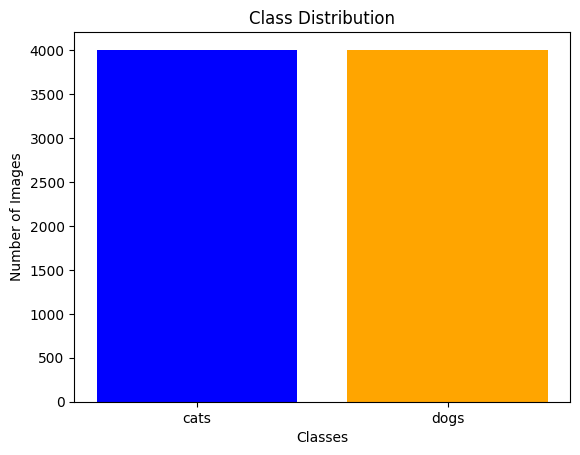

Cats: 4000 images
Dogs: 4005 images


In [9]:
# Count occurrences of each label
label_counts = collections.Counter(int(label.numpy()) for _, label in train_dataset.unbatch())

# Class names
class_names = train_dataset.class_names

# Plot class distribution
plt.bar(class_names, [label_counts[0], label_counts[1]], color=['blue', 'orange'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()

# Print counts
print(f"Cats: {label_counts[0]} images")
print(f"Dogs: {label_counts[1]} images")

Our dataset is fairly balanced, so we don’t need to apply special balancing techniques

# Preprocess Data 📦

## Split Data ✂️

In [10]:
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Our dataset is batched because the first dimension in TensorSpec is None, meaning it represents a batch of samples.

In [10]:
# Define split ratio
train_ratio = 0.8  # 80% training, 20% validation

# Compute total batches
total_batches = tf.data.experimental.cardinality(train_dataset).numpy()
train_size = int(total_batches * train_ratio)

# Split dataset
train_data = train_dataset.take(train_size)  # First 80% batches for training
valid_data = train_dataset.skip(train_size)  # Remaining 20% for validation

# Verify split
print(f"Training Batches: {tf.data.experimental.cardinality(train_data).numpy()}")
print(f"Validation Batches: {tf.data.experimental.cardinality(valid_data).numpy()}")

Training Batches: 400
Validation Batches: 101


## Resize and Scale 📏

In [11]:
# Define the resizing and normalization function
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0 
    return image, label

# Apply preprocessing to the datasets
train_data = train_data.map(preprocess).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_data = test_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)

# Verify with a sample
for image, label in train_data.unbatch().take(1):
    print(image.shape) 
    print(label)  # Corresponding label

(224, 224, 3)
tf.Tensor(1, shape=(), dtype=int32)


Now that we've explored our data, checked out some samples, and split it up, it's time to build our CNN model!

We'll start with a baseline model—a simple CNN to see how well it performs before we fine-tune things. Think of it as our starting point before we dive into optimizations. Let’s get coding! 😃

# Baseline CNN Model 🧠

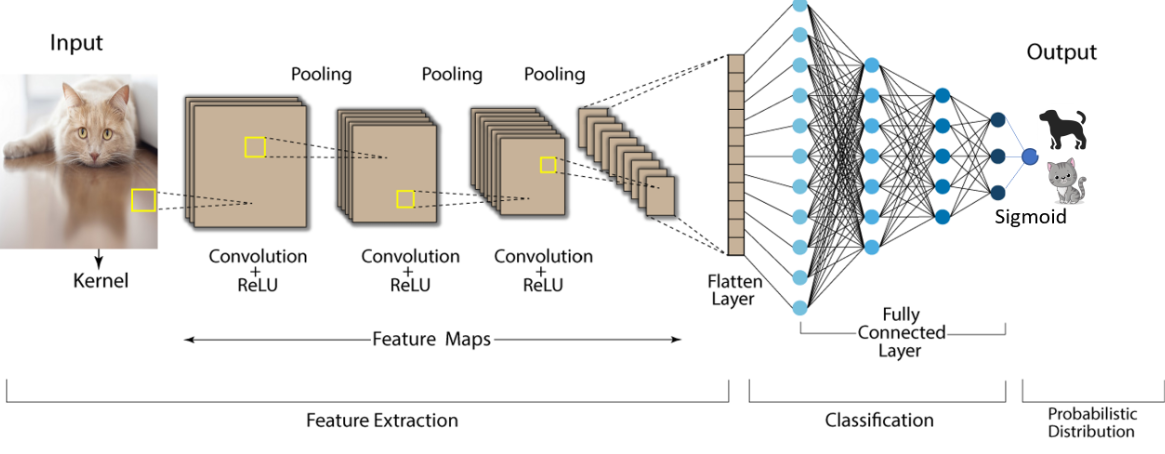

## Build 🪜

In [12]:
model = Sequential()

model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## Train 🏋️‍♂️

In [13]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - accuracy: 0.5335 - loss: 0.7232 - val_accuracy: 0.5794 - val_loss: 0.6834
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.6116 - loss: 0.6662 - val_accuracy: 0.6380 - val_loss: 0.6396
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.6705 - loss: 0.6114 - val_accuracy: 0.7209 - val_loss: 0.5522
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.7699 - loss: 0.4770 - val_accuracy: 0.7271 - val_loss: 0.5935
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8520 - loss: 0.3333 - val_accuracy: 0.7477 - val_loss: 0.6747


## Evaluate 🔬

In [14]:
results_cnn = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_cnn[1]*100:.2f}%")
print(f"Test Loss: {results_cnn[0]:.5f}")

Test Accuracy: 71.33%
Test Loss: 0.80142


## Plot performance 📉

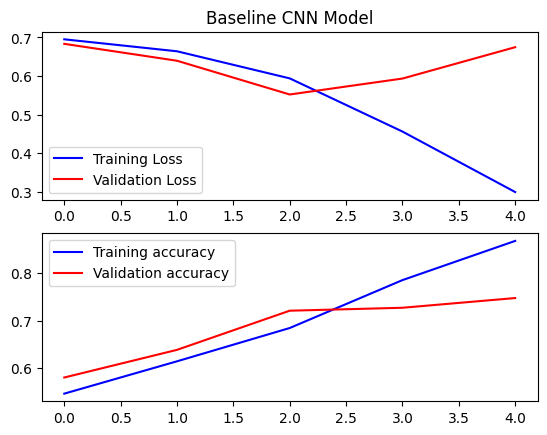

In [15]:
# plot training history
fix, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].set_title("Baseline CNN Model")
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend()
plt.show()

Our baseline CNN model is **memorizing the training data too well** but **struggling with new images**—yep, it's overfitting! 😅 It’s like a student who aces practice tests but gets confused in the real exam. Time to fine-tune and help our model **generalize better!** 🚀

# Fine-Tune CNN Model 🎯

In [18]:
model = Sequential()

model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
BatchNormalization(),  # Add Batch Normalization
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
BatchNormalization(),  # Add Batch Normalization
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
BatchNormalization(),  # Add Batch Normalization
model.add(MaxPooling2D((2, 2)))

Conv2D(256, (3, 3), activation='relu'),  # Additional layer for deeper feature extraction
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),

model.add(Flatten())

model.add(Dense(512, activation='relu'))  # Increased neurons for better learning capacity
Dropout(0.5),

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate for finer adjustments
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_data, 
    epochs=10,
    validation_data=valid_data)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.5812 - loss: 0.6730 - val_accuracy: 0.6972 - val_loss: 0.5760
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.7304 - loss: 0.5368 - val_accuracy: 0.7377 - val_loss: 0.5334
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.8008 - loss: 0.4401 - val_accuracy: 0.7545 - val_loss: 0.5250
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8428 - loss: 0.3686 - val_accuracy: 0.7389 - val_loss: 0.5671
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8724 - loss: 0.2964 - val_accuracy: 0.7464 - val_loss: 0.5894
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9112 - loss: 0.2272 - val_accuracy: 0.7576 - val_loss: 0.6324
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9462 - loss: 0.1614 - val_accuracy: 0.7533 - val_loss: 0.6849
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9578 - loss: 0.1243 - 

Test Accuracy: 74.10%
Test Loss: 1.05080


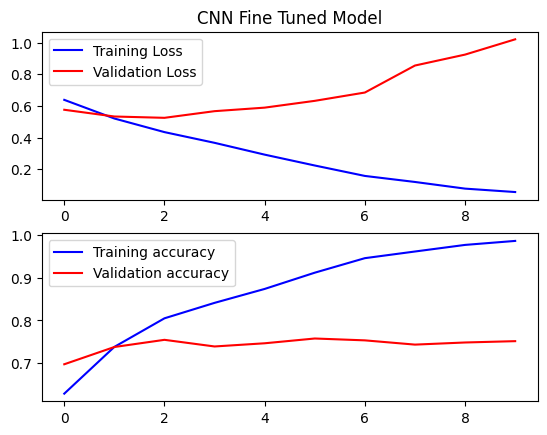

In [20]:
# Evaluate
results_cnnft = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_cnnft[1]*100:.2f}%") 
print(f"Test Loss: {results_cnnft[0]:.5f}")

# plot training history
fix, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].set_title("CNN Fine Tuned Model")
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend()
plt.show()

Alright, so our fine-tuned CNN barely improved.. not exactly a game-changer 😅 To really break past 80-90%, we need something stronger! 💪 

Time to bring in transfer learning with VGG16 and MobileNetV2 and let the pre-trained models do the heavy lifting! 🚀🔥

# VGG16 📦

## Base model VGG116 🧩

In [21]:
# Load pre-trained VGG16 without top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional layers

# Build model using Sequential
model_vgg16 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")  # Binary classification (cats vs dogs)
])

# Compile model
model_vgg16.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Train model and store history
history = model_vgg16.fit(train_data, validation_data=valid_data, epochs=5)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 63s 124ms/step - accuracy: 0.7949 - loss: 0.6145 - val_accuracy: 0.9115 - val_loss: 0.2168
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.9066 - loss: 0.2299 - val_accuracy: 0.9227 - val_loss: 0.1858
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.9184 - loss: 0.1945 - val_accuracy: 0.9159 - val_loss: 0.1893
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 109ms/step - accuracy: 0.9129 - loss: 0.1978 - val_accuracy: 0.9016 - val_loss: 0.2275
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 109ms/step - accuracy: 0.9389 - loss: 0.1614 - val_accuracy: 0.9196 - val_loss: 0.2099
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.9340 - loss: 0.1674 - val_accuracy: 0.9265 - val_loss: 0.1995
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 109ms/step - accuracy: 0.9412 - loss: 0.1468 - val_accuracy: 0.9259 - val_loss: 0.1988
Epoch 8/10
400/400 ━━━━━━━━━━━━━

Test Accuracy: 74.10%
Test Loss: 1.05080


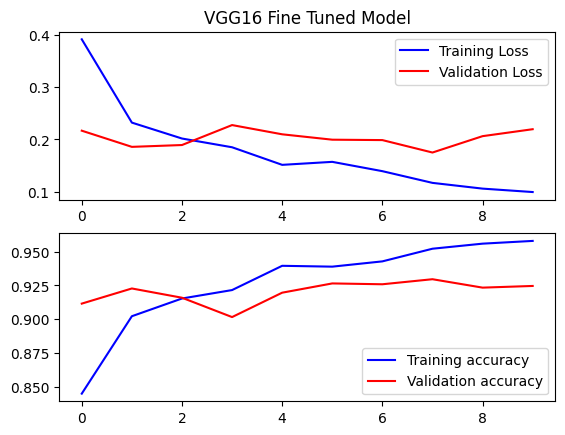

In [22]:
# Evaluate model
results_vgg16 = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_vgg16[1]*100:.2f}%")
print(f"Test Loss: {results_vgg16[0]:.5f}")

# plot training history
fix, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].set_title("VGG16 Fine Tuned Model")
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend()
plt.show()

Hummmm ..Our fine-tuned CNN and the baseline VGG16 have reached the same level of accuracy—it's a tie! 😅 But we know VGG16 has more potential.  

💪 Let’s enhance it with **data augmentation** and push beyond this barrier! 🚀🔥

## VGG16 with Data Augmentation 🎨

In [23]:
# Data Augmentation Layer (Outside .map())
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

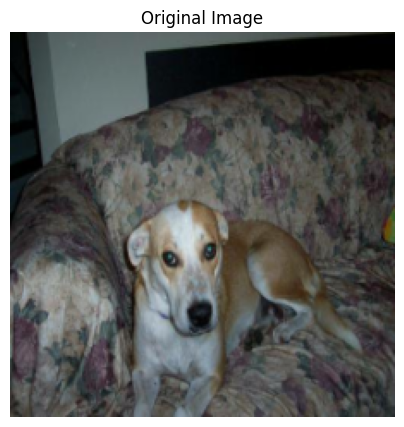

In [24]:
# Take one batch from train_data
for image_batch, label_batch in train_data.take(1):
    sample_image = image_batch[0]  # Take first image from batch
    break

# Convert tensor to numpy for visualization
sample_image = sample_image.numpy()

# Show original image
plt.figure(figsize=(5, 5))
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

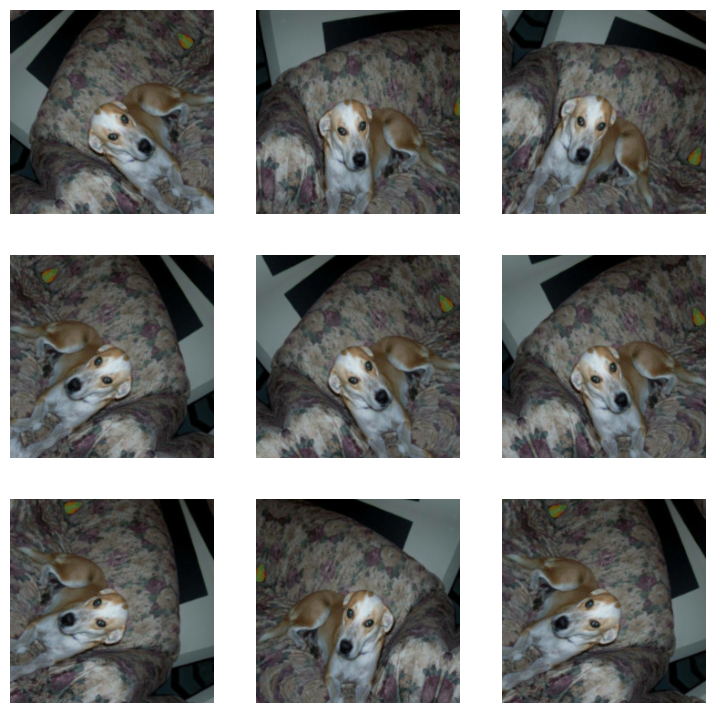

In [25]:
# Number of augmented images
num_augmented_images = 9  

# Create a figure
plt.figure(figsize=(9, 9))

for i in range(num_augmented_images):
    # Apply augmentation multiple times
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))  # Add batch dimension
    augmented_image = augmented_image[0].numpy()  # Convert tensor to numpy

    # Display each augmented image
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")  # Remove axis labels

plt.show()

We’ve set up **data augmentation**, and now it’s time to put it to work! 

💪 Let’s use it with **VGG16 fine-tuning** and see if we can finally push our accuracy! 🚀🔥

In [26]:
# Load Pre-trained VGG16
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Unfreeze only the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Build Model with Data Augmentation
model_vgg16_da = Sequential([
    data_augmentation,  # Apply augmentation before feeding into VGG16
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model_vgg16_da.compile(optimizer=optimizers.Adam(learning_rate=1e-4), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# Train Model
history = model_vgg16_da.fit(
    train_data,
    validation_data=valid_data,
    epochs=5
)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 147ms/step - accuracy: 0.7682 - loss: 0.4564 - val_accuracy: 0.9445 - val_loss: 0.1356
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 56s 140ms/step - accuracy: 0.9081 - loss: 0.2113 - val_accuracy: 0.9526 - val_loss: 0.1354
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 57s 142ms/step - accuracy: 0.9373 - loss: 0.1628 - val_accuracy: 0.9607 - val_loss: 0.1006
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 57s 142ms/step - accuracy: 0.9427 - loss: 0.1490 - val_accuracy: 0.9670 - val_loss: 0.0967
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 56s 141ms/step - accuracy: 0.9508 - loss: 0.1220 - val_accuracy: 0.9657 - val_loss: 0.0971


Test Accuracy: 96.14%
Test Loss: 0.10220


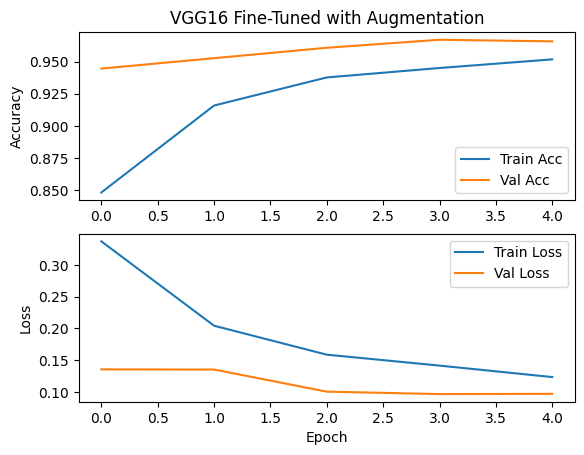

In [27]:
results_vgg16_da = model_vgg16_da.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_vgg16_da[1]*100:.2f}%") 
print(f"Test Loss: {results_vgg16_da[0]:.5f}")

# Plot Training History
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('VGG16 Fine-Tuned with Augmentation')

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

Boom! 💥 **95% accuracy** with fine-tuned VGG16! 🎉 

Now, let’s see if we can **push it even further** with **MobileNetV2**—a lighter, faster model that might just surprise us! 🚀🔥

# MobileNetV2 With Augmentation 🎨

## Train and Evaluate the model 🏋️‍♂️

In [42]:
# Load Pre-trained MobileNetV2 (Frozen Weights)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Keep all layers frozen

# Build Model
model_mobilev2 = Sequential([
    data_augmentation,  # Apply augmentation before MobileNetV2
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")  # Binary classification
])

# Compile Model
model_mobilev2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4 ), 
                       loss="binary_crossentropy", 
                       metrics=["accuracy"])

# Train Model
history = model_mobilev2.fit(
    train_data,
    epochs=5, 
    validation_data=valid_data
)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.8885 - loss: 0.2593 - val_accuracy: 0.9844 - val_loss: 0.0527
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9510 - loss: 0.1204 - val_accuracy: 0.9844 - val_loss: 0.0473
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9525 - loss: 0.1142 - val_accuracy: 0.9819 - val_loss: 0.0509
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9562 - loss: 0.1062 - val_accuracy: 0.9813 - val_loss: 0.0492
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9590 - loss: 0.1012 - val_accuracy: 0.9832 - val_loss: 0.0448


Test Accuracy: 98.42%
Test Loss: 0.04344


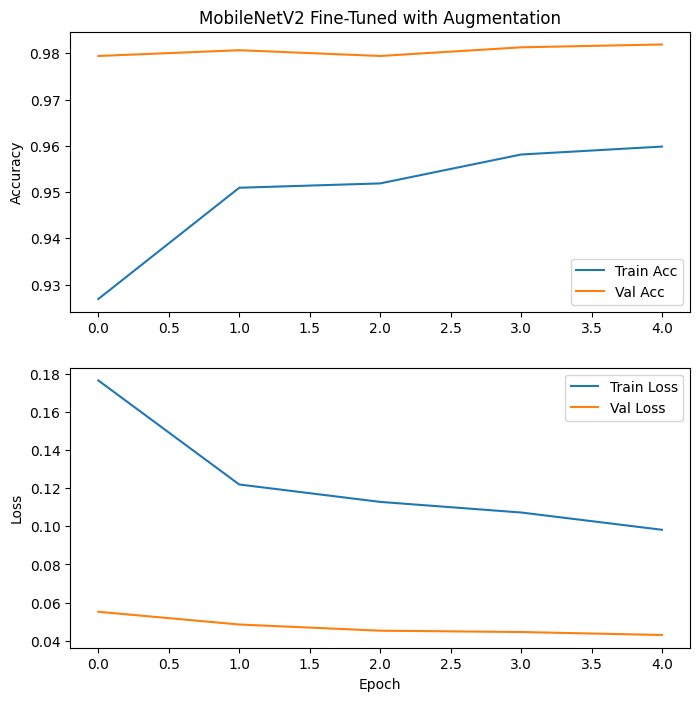

In [29]:
results_mobilev2 = model_mobilev2.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_mobilev2[1]*100:.2f}%") 
print(f"Test Loss: {results_mobilev2[0]:.5f}")

# Plot the training history
plt.figure(figsize=(8, 8))

# Accuracy Plot
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Fine-Tuned with Augmentation')

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

🔥 BOOM! 98% ACCURACY! 🎯🚀 MobileNetV2 just crushed it! 💥

Looks like transfer learning + fine-tuning + augmentation really paid off!!

## Predictions 🔮

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


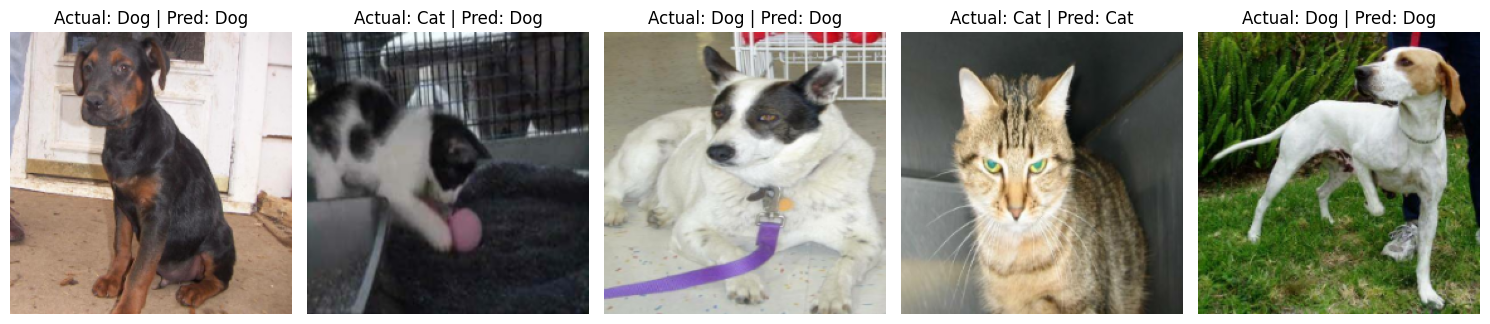

In [30]:
# Define the number of images you want to display
num_images = 5

# Create a 1-row, num_images-column grid for displaying images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate over the first batch of the test data
for images, labels in test_data.take(1):  # Take first batch from test_data
    predicted_labels = (model_mobilev2.predict(images) >= 0.5).astype(int)

    # Display the first `num_images` images in the batch with their predicted and actual labels
    for i in range(num_images):  
        ax = axes[i]  # Select the axis for the current image
        ax.imshow(images[i].numpy())  # Display image
        actual_label = 'Cat' if labels[i].numpy() == 0 else 'Dog'  # Actual label
        predicted_label = 'Cat' if predicted_labels[i] == 0 else 'Dog'  # Predicted label
        ax.set_title(f"Actual: {actual_label} | Pred: {predicted_label}")  # Show labels
        ax.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Confusion Matrix - Classification report 🟠🔵

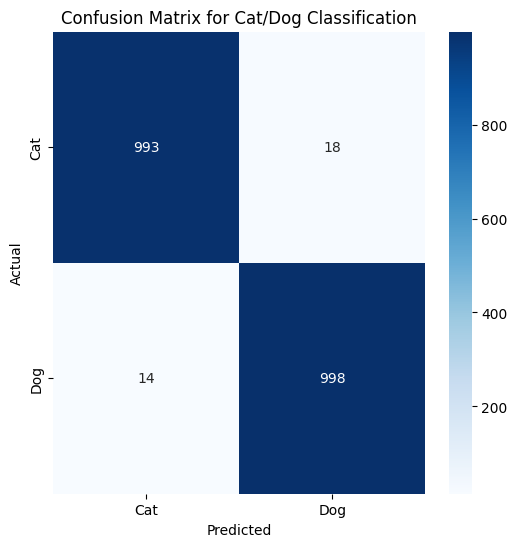

Classification Report:
              precision    recall  f1-score   support

         Cat       0.99      0.98      0.98      1011
         Dog       0.98      0.99      0.98      1012

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023



In [31]:
# Lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate through the test data to get true labels and predictions
for images, labels in test_data:
    # Predict labels for the current batch (do this once per batch)
    predicted_labels = (model_mobilev2.predict(images,  verbose=0) >= 0.5).astype(int)
    
    # Collect true labels and predicted labels
    y_true.extend(labels.numpy())  # Actual labels
    y_pred.extend(predicted_labels.flatten())  # Predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Cat/Dog Classification')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# Summary 📜

In [32]:
performance = pd.DataFrame({
    'Metrics': ['Accuracy', 'Loss'],
    'CNN': [f'{results_cnn[1] * 100:.2f}%', f'{results_cnn[0]:.2f}'],
    'CNN Fine Tuned ': [f'{results_cnnft[1] * 100:.2f}%', f'{results_cnnft[0]:.2f}'],
    'VGG26': [f'{results_vgg16[1] * 100:.2f}%', f'{results_vgg16[0]:.2f}'],
    'VGG26 Augmented ': [f'{results_vgg16_da[1] * 100:.2f}%', f'{results_vgg16_da[0]:.2f}'],
    'MobileNetV2 Augmented ': [f'{results_mobilev2[1]* 100:.2f}%', f'{results_mobilev2[0]:.2f}']
})

# Print the performance DataFrame
print(performance.set_index('Metrics').T)

Metrics                Accuracy  Loss
CNN                      71.33%  0.80
CNN Fine Tuned           74.10%  1.05
VGG26                    74.10%  1.05
VGG26 Augmented          96.14%  0.10
MobileNetV2 Augmented    98.42%  0.04


Now, let’s  **save our best model for future use**, and finally, **run some predictions on external images** to see it in action! 🚀

# Run Inference ⚡

## Save the model 💾

In [43]:
model_mobilev2.save("cat_vs_dog_model.keras")

## Load the model 📥

In [44]:
model_catdog= load_model('cat_vs_dog_model.keras')

## Predict from an Image URL 🔮

In [45]:
# Preprocesses an image for model prediction
def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to model input shape
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Runs model prediction
def make_prediction(img_array, model, threshold=0.6):
    prediction = model.predict(img_array, verbose=0)[0][0]  # Get probability
    confidence = abs(prediction - 0.5) * 2  # Convert to confidence score (0-1)
    
    if confidence < 0.4:  
        most_likely_label = "Cat" if prediction < 0.5 else "Dog"
        return f"Uncertain: {most_likely_label}", confidence  # Show uncertainty + likely label
    
    binary_label = int(prediction >= 0.5)  # Convert probability to binary label
    predicted_label = "Cat" if binary_label == 0 else "Dog"
    
    return predicted_label, confidence  # Return label + confidence

# Displays the image with the predicted label and confidence percentage
def display_prediction(img, predicted_label, confidence):
    plt.imshow(img)
    plt.title(f"{predicted_label} ({confidence*100:.1f}% confidence)")
    plt.axis("off")
    plt.show()

In [46]:
# Predict an image from a URL
def predict_image_from_url(url, model):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Handle bad responses
        
        # Check if content type is an image
        if "image" not in response.headers["Content-Type"]:
            print("Error: URL does not contain a valid image.")
            return None
        
        response.raw.decode_content = True
        
        with Image.open(response.raw).convert("RGB") as img:
            img_array = preprocess_image(img)
            predicted_label, confidence = make_prediction(img_array, model)

            display_prediction(img, predicted_label, confidence)
            return predicted_label

    except requests.exceptions.RequestException as e:
        print(f"Error fetching image: {e}")
        return None
    except PIL.UnidentifiedImageError:
        print("Error: The image file could not be identified. Ensure the URL points to a valid image.")
        return None

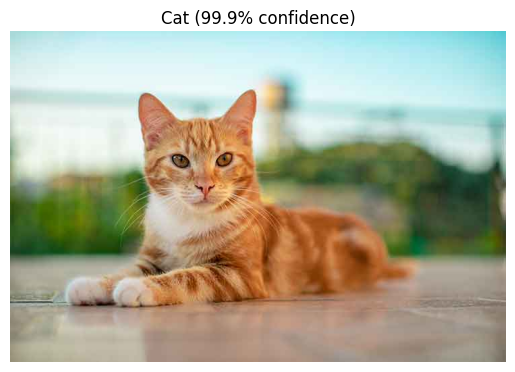

'Cat'

In [47]:
url = "https://vetmarlborough.co.nz/wp-content/uploads/cat-facts.jpg"
predict_image_from_url(url, model_catdog)

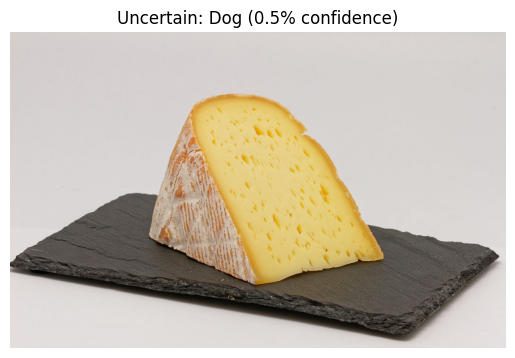

'Uncertain: Dog'

In [48]:
url = "https://radiomontblanc.fr/photos/articles/vignettes/fromage-pyrenees-bethmale_47828.jpg"
predict_image_from_url(url, model_catdog)

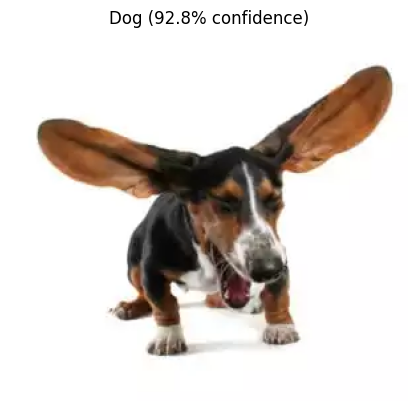

'Dog'

In [49]:
url = "https://lacvets.com/wp-content/uploads/2021/05/dog-sneezing-in-lakeland-fl-300x279.jpg"
predict_image_from_url(url, model_catdog)

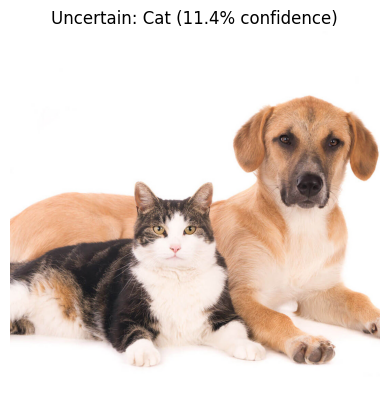

'Uncertain: Cat'

In [50]:
url = "https://petzpark.com.au/cdn/shop/articles/Dog-and-Cat-Stress_900x.jpg?v=1660605269" 
predict_image_from_url(url, model_catdog)

# Cat-Dog Classifier | Made with 🩷